In [1]:
%run ./Definitions.ipynb

2020-01-07 14:48:29.648515
thunder  Tue Jan  7 14:48:29 2020
[0] GeForce GTX 1080 Ti | 45'C,  26 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 30'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[7] GeForce GTX 1080 Ti | 28'C,   0 % | 10895 / 11178 MB | anthoula(10885M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!



In [2]:
!nvidia-smi
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "2"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

Tue Jan  7 14:48:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 32%   46C    P2    78W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

## Loading train data to use in Random Forest - union ground truth

In [3]:
tts_path = DATA_dir+'TrainTestVal/'
enc_df = pd.read_pickle(DATA_dir + 'enc_df.pkl')
y_train_df = pd.read_pickle(tts_path + 'yu_train.pkl')
y_val_df = pd.read_pickle(tts_path + 'yu_val.pkl')
y_test_df = pd.read_pickle(tts_path + 'yu_test.pkl')

In [5]:
y_train_df.shape, y_val_df.shape, y_test_df.shape

((51438, 1), (17146, 1), (17146, 1))

#### Converting the labels to list and assign 0 label to non glaucoma (2 or 3 mismatch) - FOR UNION

In [7]:
y_train = y_train_df['ClassLabel'].tolist()
y_val = y_val_df['ClassLabel'].tolist()
y_test = y_test_df['ClassLabel'].tolist()

for i in range(len(y_train)):
    if(y_train[i] != 0):
        y_train[i] = 1
        
for i in range(len(y_val)):
    if(y_val[i] != 0):
        y_val[i] = 1

for i in range(len(y_test)):
    if(y_test[i] != 0):
        y_test[i] = 1

In [8]:
indices_train = np.load(tts_path + 'indices_train.npy')
indices_val = np.load(tts_path + 'indices_val.npy')
indices_test = np.load(tts_path + 'indices_test.npy')

In [9]:
enc_df.shape, len(y_train), len(y_val), len(y_test)

((85730, 6251), 51438, 17146, 17146)

## Class Distribution

#### No. of Glaucoma and non Glaucoma patients in training set

In [10]:
n_NG = 0
n_G = 0

for i in range(len(y_train)):
    if(y_train[i] == 1):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2506
No. of non-Glaucoma patients in training set: 48932


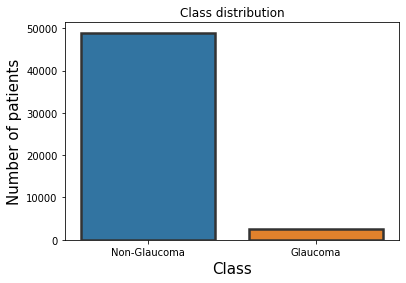

In [11]:
import seaborn as sns

class_name = ['Non-Glaucoma', 'Glaucoma']
count = [n_NG, n_G]
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of patients', fontsize=15)
plt.title('Class distribution')
plt.show()

## Assigning class weight for imbalance data set to use in Random forest classifier

In [12]:
class_weight = dict({0:1, 1:35})

## Feature Reduction and Saving Dataframe with reduced features

In [10]:
# cols2rem = ['87-','92-','135-','2227-','4689-','5181-','5326-','5327-','5945-','6119-','6148-','20002-','20008-','20009-','20010-','20011','20013-',
#             '20014-','40001-','40002-','41078-','41080-','41082-','41083-','41084-','41096-','41101-','41142-','41202-','41204-',
#             '41200-','41210-']

# # len(cols2rem) # 13
# remove_df  = enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[0])]
# for i in range(1,len(cols2rem)):
#     remove_df = remove_df.join(enc_df.loc[:,enc_df.columns.str.startswith(cols2rem[i])])
    
# new_enc_df = enc_df.drop(remove_df.columns, axis=1)
# new_enc_df.shape

### Spliting new_enc_df to train test val as per the indices

In [11]:
# meta_train = []
# meta_val = []
# meta_test = []

# for i in range(len(indices_train)):
#     meta_train.append(new_enc_df.iloc[indices_train[i]])
    
# for i in range(len(indices_val)):
#     meta_val.append(new_enc_df.iloc[indices_val[i]])
#     meta_test.append(new_enc_df.iloc[indices_test[i]])

# meta_train_arr = np.asarray(meta_train)
# meta_val_arr = np.asarray(meta_val)
# meta_test_arr = np.asarray(meta_test)

# meta_train_df = pd.DataFrame(meta_train_arr,columns = new_enc_df.columns)
# meta_val_df = pd.DataFrame(meta_val_arr,columns = new_enc_df.columns)
# meta_test_df = pd.DataFrame(meta_test_arr,columns = new_enc_df.columns)

In [12]:
# #SAVE - DONE
# meta_train_df.to_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
# meta_val_df.to_pickle(tts_path + 'reducedfeatures_meta_val.pkl')
# meta_test_df.to_pickle(tts_path + 'reducedfeatures_meta_test.pkl')

### Loading Reduced Features Encodeded Metadata - Train and Validation

In [13]:
meta_train_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_train.pkl')
meta_val_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_val.pkl')
meta_test_df = pd.read_pickle(tts_path + 'reducedfeatures_meta_test.pkl')

meta_train_df.shape, meta_val_df.shape, meta_test_df.shape, len(y_train), len(y_val), len(y_test)

((51438, 4898), (17146, 4898), (17146, 4898), 51438, 17146, 17146)

## RandomForestClassifier for Feature Importance

#### 1. Without class weights - everything is classified as majority class - High accuracy but 0 precision and recall

In [15]:
# # # Random forest classifier
# rfc_all = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
# rfc_all.fit(meta_train_df, y_train)

In [15]:
# # Saving -- DONE !!
# from sklearn.externals import joblib
# joblib.dump(rfc_all, tts_path + 'RandomForest_allfeat_union.sav')

In [16]:
# rfc_all = joblib.load(tts_path + 'RandomForest_allfeat_union.sav')

#### 2. With class weights - giving higher weight to minority class

In [17]:
rfc_all_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

In [18]:
rfc_all_cw.fit(meta_train_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Feature Dictionaries

In [19]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [20]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_all_cw, meta_train_df)

In [21]:
pd.options.display.max_colwidth = 100

fi_red = get_imp_features(50)
display_all(fi_red)

,Features,Importance
0,Taking other prescription medications,0.015771
1,Year of birth,0.011292
2,"Intra-ocular pressure, Goldmann-correlated (right)",0.010601
3,"Intra-ocular pressure, Goldmann-correlated (left)",0.009541
4,Age when attended assessment centre,0.008949
5,"Intra-ocular pressure, corneal-compensated (right)",0.008787
6,Intra-ocular pressure device ID (left),0.008729
7,Overall health rating,0.006397
8,Duration visual-acuity screen displayed (right),0.004934
9,Forced vital capacity (FVC),0.004617


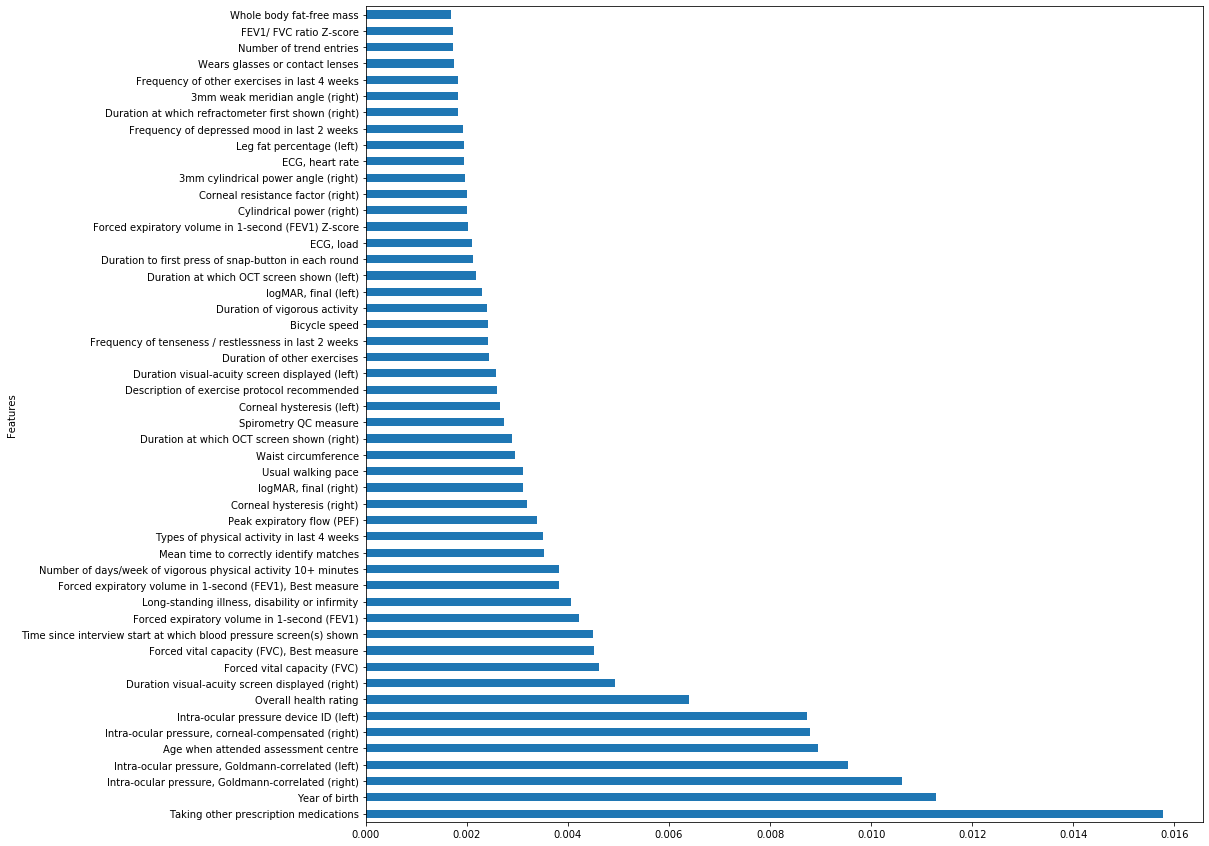

In [22]:
def plot_fi(finew):
    return finew.plot('Features','Importance','barh',figsize=(15,15),legend=False)

plot_fi(fi_red)

## Creating Dataframe containing important features

In [23]:
# Getting feature from feature description
feat_to_keep = fi_red[fi_red.Importance>0.0005].Features
featval_to_keep = []
for i in range(len(feat_to_keep)):
    for feat, desc in feat_unique_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if desc == feat_to_keep[i]:
            featval_to_keep.append(feat)
            break
            
len(featval_to_keep)

50

In [24]:
meta_train_df.shape, meta_val_df.shape, meta_test_df.shape

((51438, 4898), (17146, 4898), (17146, 4898))

In [25]:
redtrain_df = meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redtrain_df = redtrain_df.join(meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[i])])
    
redtrain_df.shape

(51438, 915)

In [26]:
redval_df = meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redval_df = redval_df.join(meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[i])])
    
redval_df.shape

(17146, 915)

In [27]:
redtest_df = meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redtest_df = redtest_df.join(meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[i])])
    
redtest_df.shape

(17146, 915)

### Saving the dataframe

In [28]:
redtrain_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df_C1.pkl')
redval_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df_C1.pkl')
redtest_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_test_df_C1.pkl')

### Loading the dataframe

In [29]:
# LOAD
redtrain_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df_C1.pkl')
redval_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df_C1.pkl')
redtest_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_test_df_C1.pkl')
redtrain_df.shape, redval_df.shape, redtest_df.shape

((51438, 915), (17146, 915), (17146, 915))

#### without class_weight

In [31]:
# rfc_red = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs=-1, oob_score = True)
# rfc_red.fit(redtrain_df, y_train)

In [32]:
# # Saving -- DONE !!
# from sklearn.externals import joblib
# joblib.dump(rfc_red, tts_path + 'RandomForest_redfeat_union.sav')

#### with class weight

In [33]:
rfc_red_cw = RandomForestClassifier(bootstrap=True,
                                    class_weight=class_weight, criterion='gini',
                                    max_depth=8, max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, min_impurity_split=None,
                                    min_samples_leaf=4, min_samples_split=10,
                                    min_weight_fraction_leaf=0.0, n_estimators=300,
                                    n_jobs=-1, oob_score=True,
                                    verbose=0, warm_start=False)

rfc_red_cw.fit(redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

### Loading Reduced features random forest

In [32]:
# rfc_red = joblib.load(tts_path + 'RandomForest_redfeat.sav')

In [34]:
# FEATURE DESCRIPTION DICTIONARY
feat_desc = pd.read_excel(DATA_dir + 'FeatureNames.xlsx')
feat_unique = feat_desc['UDI'].str.split('-',expand=True)[0].unique()
feat_desc_dict, feat_unique_dict = feature_desc()

In [35]:
feat_imp_dict, feat_unique_imp_dict = feature_imp(rfc_red_cw, redtrain_df)
fi_red = get_imp_features(40)
display_all(fi_red)

,Features,Importance
0,Taking other prescription medications,0.026463
1,"Intra-ocular pressure, Goldmann-correlated (right)",0.023485
2,"Intra-ocular pressure, corneal-compensated (right)",0.021165
3,Year of birth,0.019478
4,Age when attended assessment centre,0.017916
5,"Intra-ocular pressure, Goldmann-correlated (left)",0.016544
6,Overall health rating,0.012553
7,Time since interview start at which blood pressure screen(s) shown,0.009110
8,Forced expiratory volume in 1-second (FEV1),0.008721
9,Number of days/week of vigorous physical activity 10+ minutes,0.008327


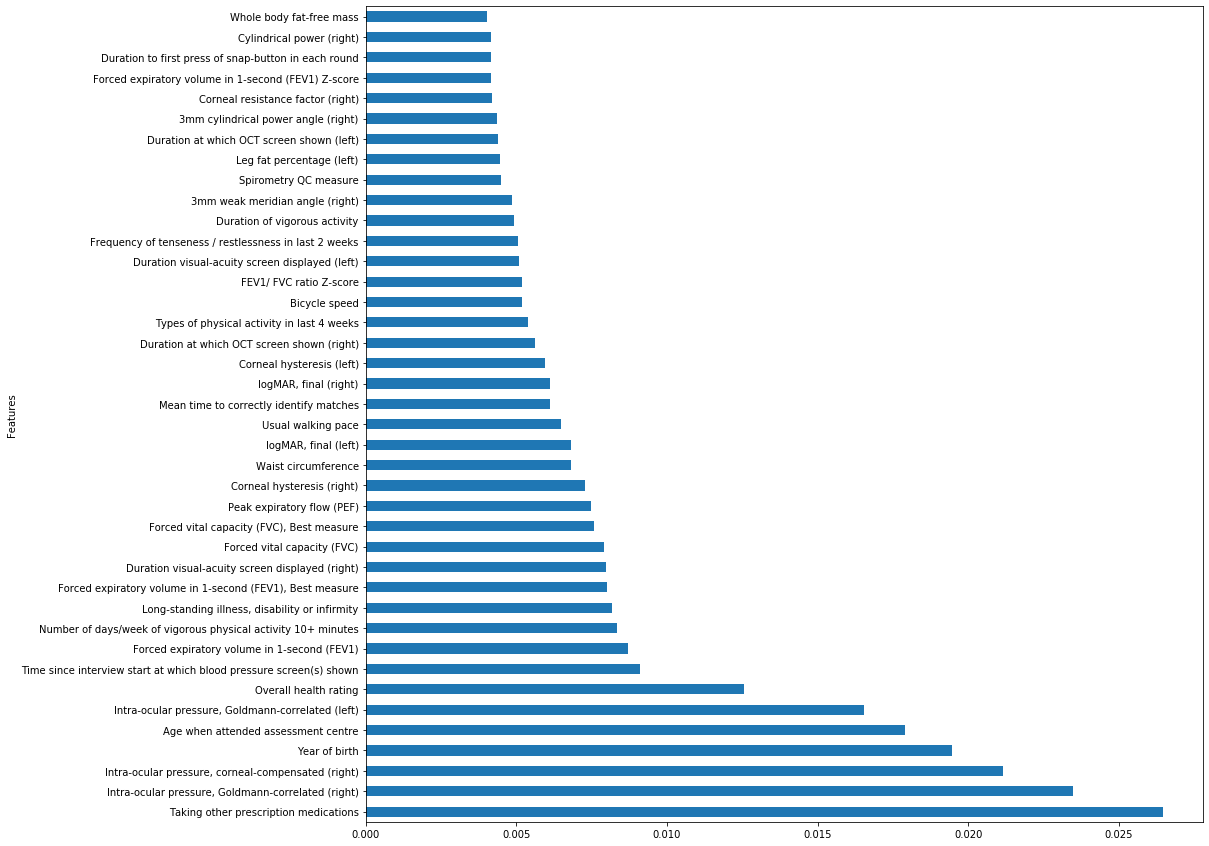

In [36]:
plot_fi(fi_red)

## Compare The Accuracy Of Full Feature Classifier To Limited Feature Classifier


In [37]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix

# Full Featured Classifier To The Test Data
y_pred = rfc_all_cw.predict(meta_val_df)
y_important_pred = rfc_red_cw.predict(redval_df)

In [69]:
all_pred_train = rfc_all_cw.predict(meta_train_df)
all_pred_val = rfc_all_cw.predict(meta_val_df)
all_pred_test = rfc_all_cw.predict(meta_test_df)

In [46]:
meta_val_df.shape, redval_df.shape

((17146, 4898), (17146, 915))

#### F1 score

In [38]:
# 40 features
f1_score(y_val, y_pred) , f1_score(y_val, y_important_pred)

(0.13250517598343686, 0.13277441996490547)

#### Accuracy score

In [39]:
accuracy_score(y_val, y_pred) , accuracy_score(y_val, y_important_pred)

(0.4623818966522804, 0.4811617870057156)

#### Recall score

In [40]:
recall_score(y_val, y_pred) , recall_score(y_val, y_important_pred)

(0.8262910798122066, 0.7992957746478874)

#### Precision score

In [41]:
precision_score(y_val, y_pred) , precision_score(y_val, y_important_pred)

(0.07202782893390629, 0.07240059536466086)

#### classification_report

In [42]:
print(classification_report(y_val, y_pred) ,"\n\n", classification_report(y_val, y_important_pred))

              precision    recall  f1-score   support

           0       0.98      0.44      0.61     16294
           1       0.07      0.83      0.13       852

    accuracy                           0.46     17146
   macro avg       0.53      0.63      0.37     17146
weighted avg       0.93      0.46      0.59     17146
 

               precision    recall  f1-score   support

           0       0.98      0.46      0.63     16294
           1       0.07      0.80      0.13       852

    accuracy                           0.48     17146
   macro avg       0.53      0.63      0.38     17146
weighted avg       0.93      0.48      0.61     17146



#### Confusion matrix

In [43]:
# tn, fp, fn, tp
print(confusion_matrix(y_val, y_pred) ,"\n\n", confusion_matrix(y_val, y_important_pred))

[[7224 9070]
 [ 148  704]] 

 [[7569 8725]
 [ 171  681]]


Healthy Patients - correctly identified (True Negatives):  7224 0.44335338161286364
Healthy Patients - predicted to have glaucoma (False Positives):  9070 0.5566466183871364
Glaucoma Patients - predicted healthy (False Negatives):  148 0.17370892018779344
Glaucoma Patients - correctly identified (True Positives):  704 0.8262910798122066

Total Glaucoma patients:  852 1.0
Total Healthy patients:  16294 1.0


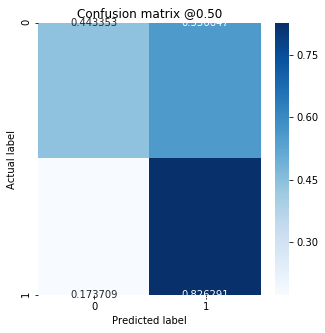

In [44]:
plot_cm(y_val, y_pred)

Healthy Patients - correctly identified (True Negatives):  7569 0.4645268196882288
Healthy Patients - predicted to have glaucoma (False Positives):  8725 0.5354731803117712
Glaucoma Patients - predicted healthy (False Negatives):  171 0.2007042253521127
Glaucoma Patients - correctly identified (True Positives):  681 0.7992957746478874

Total Glaucoma patients:  852 1.0
Total Healthy patients:  16294 1.0


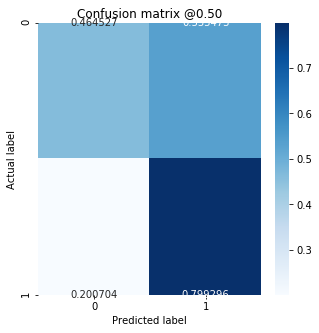

In [45]:
plot_cm(y_val, y_important_pred)

In [70]:
get_metrics(y_train, y_val, y_test, all_pred_train, all_pred_val, all_pred_test)

Metrics:		Train:			Validation:		Test:
Accuracy:	 0.4805396788366577 	 0.4623818966522804 	 0.4631984136241689
Recall:		 0.9736632083000798 	 0.8262910798122066 	 0.7924757281553398
Precision:	 0.08386608922801952 	 0.07202782893390629 	 0.0674168903572166
F1 score:	 0.15443037974683546 	 0.13250517598343686 	 0.12426260704091341
AUC:		 0.714474046723407 	 0.6348222307125351 	 0.6195254513831472


## Creating and saving Dataframe containing final 40 features only


In [47]:
# Getting feature from feature description
feat_to_keep = fi_red.Features
featval_to_keep = []
for i in range(len(feat_to_keep)):
    for feat, desc in feat_unique_dict.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if desc == feat_to_keep[i]:
            featval_to_keep.append(feat)
            break
            
len(featval_to_keep)

40

In [48]:
redtrain_df = meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redtrain_df = redtrain_df.join(meta_train_df.loc[:,meta_train_df.columns.str.startswith(featval_to_keep[i])])
    
redtrain_df.shape

(51438, 444)

In [49]:
redval_df = meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redval_df = redval_df.join(meta_val_df.loc[:,meta_val_df.columns.str.startswith(featval_to_keep[i])])
    
redval_df.shape

(17146, 444)

In [50]:
redtest_df = meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[0])]
for i in range(1,len(featval_to_keep)):
    redtest_df = redtest_df.join(meta_test_df.loc[:,meta_test_df.columns.str.startswith(featval_to_keep[i])])
    
redtest_df.shape

(17146, 444)

In [51]:
redtrain_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df_FINAL.pkl')
redval_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df_FINAL.pkl')
redtest_df.to_pickle(tts_path + str(len(featval_to_keep))+'_features_union_test_df_FINAL.pkl')

## Loading

In [52]:
# LOAD
final_redtrain_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_train_df_FINAL.pkl')
final_redval_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_val_df_FINAL.pkl')
final_redtest_df = pd.read_pickle(tts_path + str(len(featval_to_keep))+'_features_union_test_df_FINAL.pkl')
final_redtrain_df.shape, final_redval_df.shape, final_redtest_df.shape

((51438, 444), (17146, 444), (17146, 444))

## FINAL Performance on using important features only

In [56]:
rfc_imp = RandomForestClassifier(bootstrap=True,
                                class_weight=class_weight, criterion='gini',
                                max_depth=8, max_features='auto', max_leaf_nodes=None,
                                min_impurity_decrease=0.0, min_impurity_split=None,
                                min_samples_leaf=4, min_samples_split=10,
                                min_weight_fraction_leaf=0.0, n_estimators=300,
                                n_jobs=-1, oob_score=True,
                                verbose=0, warm_start=False)

rfc_imp.fit(final_redtrain_df, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 35},
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [58]:
# True Values: y_train, y_val, y_test

#Predicted Values
imp_train_pred = rfc_imp.predict(final_redtrain_df)
imp_val_pred = rfc_imp.predict(final_redval_df)
imp_test_pred = rfc_imp.predict(final_redtest_df)


In [63]:
get_metrics(y_train, y_val, y_test, imp_train_pred, imp_val_pred, imp_test_pred)

Metrics:		Train:			Validation:		Test:
Accuracy:	 0.524612154438353 	 0.5036743263734982 	 0.504607488627085
Recall:		 0.9573024740622506 	 0.7910798122065728 	 0.7633495145631068
Precision:	 0.08969900916059076 	 0.07483899622473907 	 0.07045250896057348
F1 score:	 0.16402858021947966 	 0.13674173260296207 	 0.12899917965545532
AUC:		 0.7298774284804836 	 0.6398629698077175 	 0.6274473341716404


Healthy Patients - correctly identified (True Negatives):  24586 0.5024523828987166
Healthy Patients - predicted to have glaucoma (False Positives):  24346 0.4975476171012834
Glaucoma Patients - predicted healthy (False Negatives):  107 0.0426975259377494
Glaucoma Patients - correctly identified (True Positives):  2399 0.9573024740622506

Total Glaucoma patients:  2506 1.0
Total Healthy patients:  48932 1.0


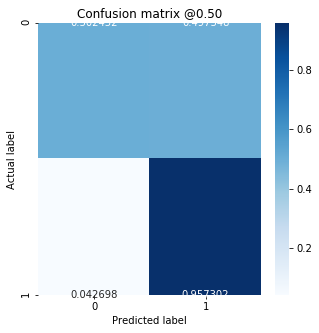

In [66]:
plot_cm(y_train, imp_train_pred)

Healthy Patients - correctly identified (True Negatives):  7962 0.48864612740886215
Healthy Patients - predicted to have glaucoma (False Positives):  8332 0.5113538725911378
Glaucoma Patients - predicted healthy (False Negatives):  178 0.20892018779342722
Glaucoma Patients - correctly identified (True Positives):  674 0.7910798122065728

Total Glaucoma patients:  852 1.0
Total Healthy patients:  16294 1.0


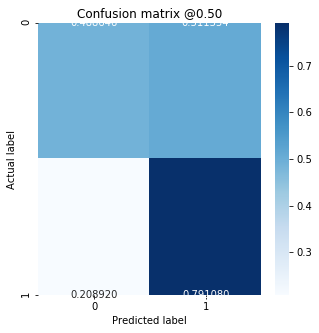

In [64]:
plot_cm(y_val, imp_val_pred)

Healthy Patients - correctly identified (True Negatives):  8023 0.491545153780174
Healthy Patients - predicted to have glaucoma (False Positives):  8299 0.508454846219826
Glaucoma Patients - predicted healthy (False Negatives):  195 0.2366504854368932
Glaucoma Patients - correctly identified (True Positives):  629 0.7633495145631068

Total Glaucoma patients:  824 1.0
Total Healthy patients:  16322 1.0


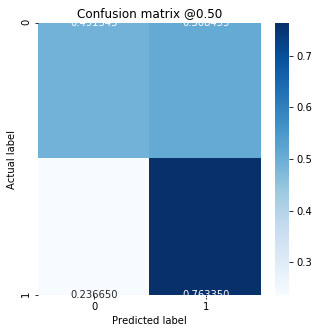

In [65]:
plot_cm(y_test, imp_test_pred)